# Bin tag applier. 
This model implements the binary tagging model that was developed in notebook `/notebooks/machine learning notebooks/1 - usability tagger.ipynb`

In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
import os
import sys
import re
from tqdm import tqdm


sys.path.append('../../utils')
import config_handling as conf
from database import Database
from file_io import path_handler
from cnn_helpers import preprocess_image, system_override

2025-02-03 17:33:23.261026: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [18]:
# Load configuration
config = conf.read_config('../../config/automotive.conf.ini')
config.read('config.ini')
connection_type = config['settings']['connection']
user = config[connection_type]['user']
pw = config[connection_type]['pw']
host = config[connection_type]['host']
db = config[connection_type]['db']
port = config[connection_type].getint('port')
db = Database(host,
              port,
              user,
              pw,
              db
              )
db.connect()

# Image directory
basedir = config['settings']['image_directory']

Connection established


In [3]:
table_query = """CREATE TABLE IF NOT EXISTS bintag_predicts (
    image_id INT PRIMARY KEY,
    model1_results FLOAT
);"""
db.execute_query(table_query)

[]

In [4]:
batch_size = 5000

In [5]:
img_query = "SELECT * FROM images;"
img_table = pd.DataFrame(db.execute_query(img_query))

In [6]:
print(len(img_table))

15647260


In [7]:
system_override()

physical_devices = tf.config.list_physical_devices('GPU')
if len(physical_devices) > 0:
    device = 'GPU'
    tf.config.set_visible_devices(physical_devices[0], 'GPU')
else:
    device = 'CPU'

# Print the device being used
print(f"Using {device} for deep learning.")

System override applied - check if GPU is detected
Using GPU for deep learning.


2025-02-03 17:35:24.163019: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:26.478853: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:26.478918: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero


In [8]:
img_table = img_table.fillna(-1)
img_table[['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']] = img_table[['yolobox_top_left_x', 'yolobox_top_left_y', 'yolobox_bottom_right_x', 'yolobox_bottom_right_y']].astype(int)
img_table['image_path'] = img_table['image_path'].apply(lambda x: path_handler(basedir, x))

/tmp/ipykernel_347620/3323961686.py:1: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  img_table = img_table.fillna(-1)


In [9]:
img_table.sample(5)

,id,listing_id,processed,use_image,certainty_of_outside_yolo,yolobox_top_left_x,yolobox_top_left_y,yolobox_bottom_right_x,yolobox_bottom_right_y,area,confidence,image_path
5717963,6374844,383763,1,0,-1,-1,-1,-1,-1,-1.000000,-1.000000,/home/frederic/Documents/automotive_image_data...
6494273,7154549,430307,1,0,-1,-1,-1,-1,-1,-1.000000,-1.000000,/home/frederic/Documents/automotive_image_data...
1314520,1564205,100692,1,0,-1,-1,-1,-1,-1,-1.000000,-1.000000,/home/frederic/Documents/automotive_image_data...
6608866,7269142,437721,1,1,-1,62,27,584,358,0.548319,0.951342,/home/frederic/Documents/automotive_image_data...
1428595,1678280,107831,1,0,-1,-1,-1,-1,-1,-1.000000,-1.000000,/home/frederic/Documents/automotive_image_data...


In [10]:
use_bbox = True
rastersize = 64
name = 'best_model-Epochs=5-raster=64-bbox=True.keras'
model_dir = os.path.join(os.getcwd(), '../../models/bin_models')
model = load_model(os.path.join(model_dir, name))

2025-02-03 17:35:53.293606: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:53.293821: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:53.293881: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:53.294161: I external/local_xla/xla/stream_executor/rocm/rocm_executor.cc:920] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2025-02-03 17:35:53.294218: I external/local_xla/xla/stream_executor/rocm/rocm_executor.

In [11]:
all_results = pd.DataFrame(columns=['id', 'predictions'])
for start in range(0, len(img_table), batch_size): 
    batch = img_table.iloc[start:start + batch_size]
    images = []
    pk_ids = batch['id']
    for _, row in batch.iterrows():
        bbox = (row['yolobox_top_left_x'], row['yolobox_top_left_y'], row['yolobox_bottom_right_x'], row['yolobox_bottom_right_y'])
        img = preprocess_image(row['image_path'], use_bbox, bbox, rastersize)
        images.append(img)
    images = np.array(images)
    predictions = model.predict(images)
    batch_df = pd.DataFrame({
        'id' : pk_ids.values, 
        'predictions' : predictions.flatten()
    })
    all_results = pd.concat([all_results, batch_df], ignore_index=True)

I0000 00:00:1738600561.271181  348985 service.cc:146] XLA service 0x715ed00064d0 initialized for platform ROCM (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1738600561.271260  348985 service.cc:154]   StreamExecutor device (0): AMD Radeon RX 6700 XT, AMDGPU ISA version: gfx1030
2025-02-03 17:36:01.279061: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.


 24/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 

I0000 00:00:1738600562.687007  348985 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


157/157 ━━━━━━━━━━━━━━━━━━━━ 3s 11ms/step


/tmp/ipykernel_347620/3298319419.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  all_results = pd.concat([all_results, batch_df], ignore_index=True)


157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
157/157 ━━━━━━━━

In [17]:
#TODO (low priority): add SQLALCHEMY or a true batch insert method to the DB class.
# actually, better not use sqlachemy, you can insert df to mysql using .to_sql(), 
# but that has it's own drawback when wanting to update/insert a single column.

batch_size = 1000
insert_query = """INSERT INTO bintag_predicts (image_id, model1_results) VALUES (%s, %s)"""
for start in tqdm(range(0, len(all_results), batch_size)):
    end = min(start + batch_size, len(all_results))
    batch = all_results.iloc[start:end]
    for row in batch.itertuples(index=False, name=None):
            db.execute_query(insert_query, params=row)


# Commit and close connection
db.commit_transaction()

100%|██████████| 15648/15648 [17:37<00:00, 14.80it/s]


Connection closed


In [33]:
#check how good your predictions are by inspecting a random grid of results: 

query = """SELECT * 
        FROM images 
        JOIN bintag_predicts 
            ON bintag_predicts.image_id = images.id
        WHERE 
            bintag_predicts.model1_results >= 0.95
        """

prediction_data = pd.DataFrame(db.execute_query(query))
prediction_data['image_path'] = prediction_data['image_path'].apply(lambda x: path_handler(basedir, x))


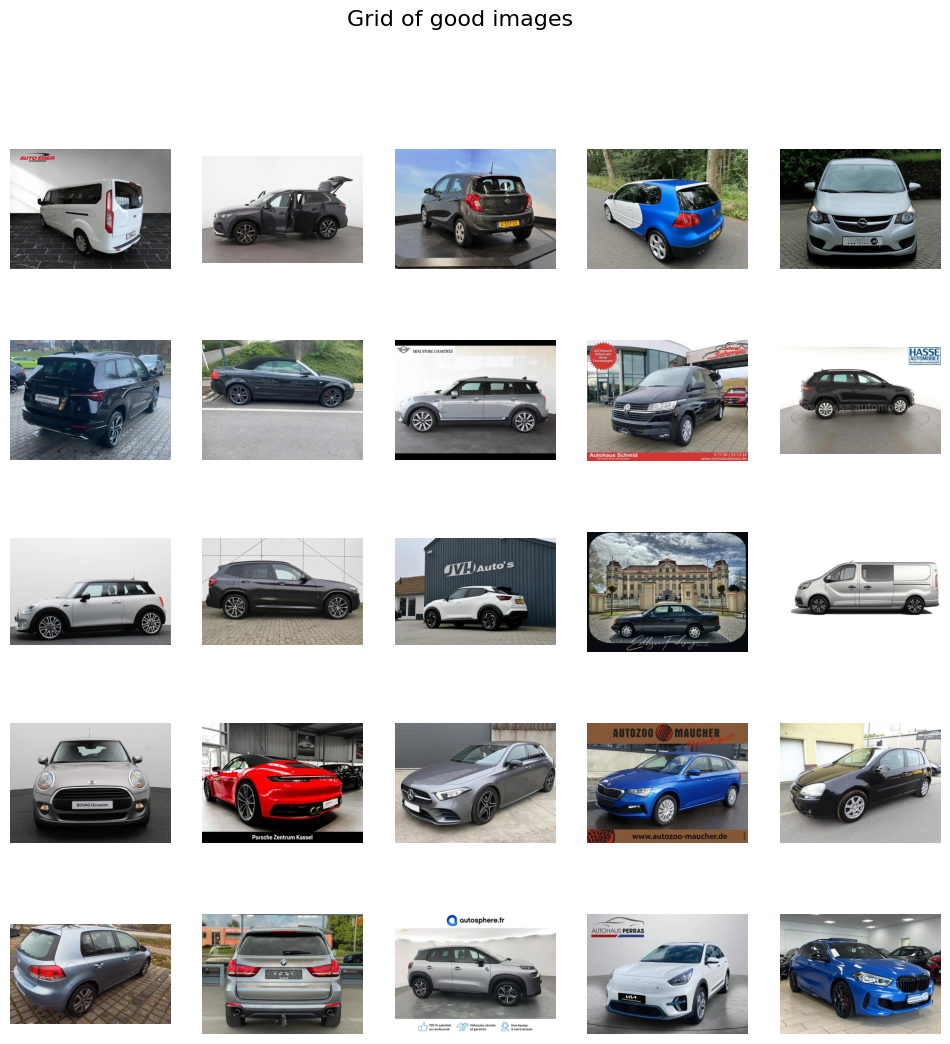

In [36]:
import matplotlib.pyplot as plt

def plot_images_as_grid(imseries, title, n=4): 
    """
    #TODO make this into utility
    creates a grid of n*n images by randomply picking n**2 images
    from a series object (imseries) and plots them into the notebook. 
    """
    samplesize = n**2
    chosen = imseries.sample(samplesize)
    fig, axes = plt.subplots(n, n, figsize=(12, 12))
    axes = axes.flatten()
    i = 0
    for image in chosen: 
        img = Image.open(image)
        axes[i].imshow(img)
        axes[i].axis('off')
        i+=1
    fig.suptitle(title, fontsize=16)

plot_images_as_grid(prediction_data['image_path'], 'Grid of good images',5)


In [ ]:
#habemus etwuk da marcheert! kzien content